<a href="https://colab.research.google.com/github/alxkzncoff/house_price_prediction/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALL

Этот шаг нужно делать, если запуск происходит через Google Colab.

In [1]:
!pip install catboost
!pip install PyDrive
!mkdir work_dir

     |████████████████████████████████| 65.8MB 56kB/s 


# DEFINE

In [2]:
DATA_PATH                   = '/content/work_dir'  # для Google drive
# DATA_PATH                   = '/data'
RANDOM_SEED                 = 42

# IMPORT

In [3]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# ADD GOOGLE DRIVE

Этот шаг нужно делать, если запуск происходит через Google Colab.

In [4]:
# Data access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Download flats.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1klMxLa0QAOdjiH_znstP4bCSUy57rUtd"}) # откуда берем файл
downloaded.GetContentFile(DATA_PATH+'/df.csv') # куда сохраняем файл в вирутальной машине колаба

# VIEW DATA

In [7]:
df = pd.read_csv(DATA_PATH+'/df.csv',
                 dtype={'rooms': str, 'floors': str, 'total_floors': str})

In [8]:
print('Data:')
display(df)
print('\n')
print('Info:')
display(df.info())
print('\n')
print("Numbers of column's unique values:")
display(df.select_dtypes('object').nunique())
print('\n')
print('Shape:')
display(df.shape)

Data:


,flat_type,object_type,rooms,floors,square,price,build_matireal,district_rating,underground,total_floors,metro_station,district
0,Квартира,Новостройка,2,11,4.070735,16.359441,Монолит,"4,0",1000.0,12,Звездная,Московский
1,Квартира,Новостройка,1,18,3.908015,15.967274,Монолит,"3,9",3600.0,20,Комендантский проспект,Приморский
2,Квартира,Вторичная,3,1,4.146304,15.363073,Панель,"3,6",1000.0,5,Обухово,Невский
3,Квартира,Вторичная,1,10,3.941582,16.341239,Монолит,"3,8",2800.0,14,Площадь Ленина,Калининский
4,Квартира,Вторичная,1,6,3.931826,16.461685,Монолит,"3,7",797.0,10,Площадь А. Невского,Центральный
...,...,...,...,...,...,...,...,...,...,...,...,...
40325,Квартира,Вторичная,3,1,4.406719,16.092778,Кирпич,"3,9",256.0,5,Удельная,Выборгский
40326,Квартира,Вторичная,3,14,4.483003,16.418571,Монолит,"3,7",3600.0,17,Площадь Ленина,Калининский
40327,Квартира,Вторичная,1,5,3.797734,16.212496,Монолит,"3,7",877.0,12,Лиговский проспект,Центральный
40328,Квартира,Вторичная,2,18,4.204693,15.830414,Монолит,"3,8",4800.0,19,Сосновая Поляна,Красносельский




Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40330 entries, 0 to 40329
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flat_type        40330 non-null  object 
 1   object_type      40330 non-null  object 
 2   rooms            40330 non-null  object 
 3   floors           40330 non-null  object 
 4   square           40330 non-null  float64
 5   price            40330 non-null  float64
 6   build_matireal   40330 non-null  object 
 7   district_rating  40330 non-null  object 
 8   underground      40330 non-null  float64
 9   total_floors     40330 non-null  object 
 10  metro_station    40330 non-null  object 
 11  district         40330 non-null  object 
dtypes: float64(3), object(9)
memory usage: 3.7+ MB


None



Numbers of column's unique values:


flat_type           2
object_type         2
rooms               5
floors             25
build_matireal      3
district_rating    10
total_floors       26
metro_station      77
district           14
dtype: int64



Shape:


(40330, 12)

In [42]:
class FlatsPredict:
    
    """
    Description:
    
        Модель предсказания цен на квартиры с помощью CatBoost
        
    Parametrs:

        categorical_features  - категориальные признаки                             | [list]
        numerical_features    - числовые признаки                                   | [list]
        TRAIN_RATIO           - объем тренировочных данных                          | float       | default - 0.75
        VALIDATION_RATIO      - объем валидационных данных                          | float       | default - 0.15
        TEST_RATIO            - объем тестовых данных                               | float       | default - 0.10
        RANDOM_SEED           - константа для воспроизводимости эксперементов       | int         | default - 42
        VERBOSE               - Как часто выводить информацию об обучении,          | int, bool   | default - 500
                                если передаем int. Выводить всю информацию или
                                не выводить, если передем bool 
        
    Methods:
    
        search_best_params()  - перебор параметров модели, для поиска лучших значений.
        fit_model()           - нормализует данные, обучает модель, рисует график 
                                обучения, возвращает датафрейм с результатом.
        
    Return:
    
        None
    
    """
 

    def __init__(self, categorical_features, numerical_features, TRAIN_RATIO=0.75, 
                 VALIDATION_RATIO=0.15, TEST_RATIO=0.10, RANDOM_SEED=42, VERBOSE=1000):
        
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.TRAIN_RATIO = TRAIN_RATIO
        self.VALIDATION_RATIO = VALIDATION_RATIO
        self.TEST_RATIO = TEST_RATIO
        self.RANDOM_SEED = RANDOM_SEED
        self.VERBOSE = VERBOSE

        
    def search_best_params(self, data, grid):

        """
        Description:

            Функция перебора параметров модели, для поиска лучших значений.

        Parametrs:

            data                  - таблица с данными                                   | DataFrame
            grid                  - словарь с параметрами, среди которых ищем лучшие    | {dict}

        Return:
        
            grid_search_result   - набор лучших параметров

        """
        
        """ Normalization """
        try:
            MMS = MinMaxScaler()
        except ValueError:
            print('You have to import MinMaxScaler from sklearn.preprocessing')
            
        MMS.fit(data[self.numerical_features])
        data[self.numerical_features] = MMS.transform(data[self.numerical_features])
        print('Data: \n')
        display(data.head(5))

        """ Train, validation, test split """
        X = data.drop(columns=['price'])
        y = data['price']
        
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - self.TRAIN_RATIO, 
                                                                shuffle = True, random_state = self.RANDOM_SEED)
            X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                            test_size = self.TEST_RATIO/(self.TEST_RATIO + self.VALIDATION_RATIO), 
                                                            shuffle = True, random_state = self.RANDOM_SEED)
        except ValueError:
            print('You have to import train_test_split from sklearn.model_selection')

        """ Data preparetion for CatBoost """
        train_data = Pool(data=X_train, label=y_train, cat_features=self.categorical_features)   # Тренировочные данные
        val_data  = Pool(data=X_val, label=y_val, cat_features=self.categorical_features)        # Валидационные данные
        test_data = Pool(data=X_test, cat_features=self.categorical_features)                    # Тестовые данные

        """ Grid search """
        try:
            model = CatBoostRegressor()
        except ValueError:
            print('You have to import CatBoostRegressor from catboost')
            
        grid_search_result = model.grid_search(grid, 
                                               train_data,  
                                               partition_random_seed=self.RANDOM_SEED,
                                               verbose=self.VERBOSE)

        return grid_search_result.params()
    
    
    def fit_model(self, data, ctr, metric='RMSE'):

        """ 
        Description:

            Функция нормализует данные, обучает модель, строит график обучения, возвращает датафрейм с результатом.

        Parametrs:

            data                  - таблица с данными                                   | DataFrame
            ctr                   - CatBoostRegressor() с параметрами                   | object
            metric                - метрика для графика                                 | str         | default - RMSE
                                   (должна совпадать с метрикой модели)

        Return:

            result                - датафрейм с истинными и предсказанными значениям    | DataFrame

        """

        """ Normalization """
        try:
            MMS = MinMaxScaler()
        except ValueError:
            print('You have to import MinMaxScaler from sklearn.preprocessing')
   
        MMS.fit(data[self.numerical_features])
        data[self.numerical_features] = MMS.transform(data[self.numerical_features])
        print('Data: \n')
        display(data.head(5))

        """ Train, validation, test split """
        X = data.drop(columns=['price'])
        y = data['price']
        
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - self.TRAIN_RATIO, 
                                                                shuffle = True, random_state = self.RANDOM_SEED)
            X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                            test_size = self.TEST_RATIO/(self.TEST_RATIO + self.VALIDATION_RATIO), 
                                                            shuffle = True, random_state = self.RANDOM_SEED)
        except ValueError:
            print('You have to import train_test_split from sklearn.model_selection')

        """ Data preparetion for CatBoost """
        train_data = Pool(data=X_train, label=y_train, cat_features=self.categorical_features)   # Тренировочные данные
        val_data  = Pool(data=X_val, label=y_val, cat_features=self.categorical_features)        # Валидационные данные
        test_data = Pool(data=X_test, cat_features=self.categorical_features)                    # Тестовые данные

        """ Fit model """
        print('\n')
        print('Learning...')
        model = ctr.fit(train_data,
                        eval_set=val_data,
                        verbose_eval=self.VERBOSE,
                        use_best_model=True)

        """ Learning curve """
        plt.figure(figsize=(12,8))
        plt.title(metric)
        plt.plot(model.evals_result_['learn'][metric], label='train')
        plt.plot(model.evals_result_['validation'][metric], label='val')
        plt.legend()
        plt.grid()
        plt.show()

        """ Val predict """
        print('Score:')
        val_predict = model.predict(X_val)
        print(f"Validation mape: {(np.mean(np.abs((val_predict-y_val)/y_val)))*100:0.2f}%")

        """ Test Predict """
        predict = model.predict(test_data)
        result_dict = {'target': np.expm1(y_test), 'predict': np.expm1(predict)}
        result = pd.DataFrame(data = result_dict)
        print(f"Test mape: {(np.mean(np.abs((predict-y_test)/y_test)))*100:0.2f}%")

        return result


In [43]:
cat = ['flat_type', 'rooms', 'object_type', 'floors', 'build_matireal', 
       'district_rating', 'total_floors',  'metro_station',  'district']
num = ['square', 'underground']

m = FlatsPredict(cat, num)

In [44]:
params = {'learning_rate': [0.001, 0.01]}

m.search_best_params(df, params)

Data: 



,flat_type,object_type,rooms,floors,square,price,build_matireal,district_rating,underground,total_floors,metro_station,district
0,Квартира,Новостройка,2,11,0.496283,16.359441,Монолит,"4,0",0.2000,12,Звездная,Московский
1,Квартира,Новостройка,1,18,0.448009,15.967274,Монолит,"3,9",0.7200,20,Комендантский проспект,Приморский
2,Квартира,Вторичная,3,1,0.518702,15.363073,Панель,"3,6",0.2000,5,Обухово,Невский
3,Квартира,Вторичная,1,10,0.457967,16.341239,Монолит,"3,8",0.5600,14,Площадь Ленина,Калининский
4,Квартира,Вторичная,1,6,0.455073,16.461685,Монолит,"3,7",0.1594,10,Площадь А. Невского,Центральный



bestTest = 5.843545394
bestIteration = 999

0:	loss: 5.8435454	best: 5.8435454 (0)	total: 19.4s	remaining: 19.4s

bestTest = 0.1769378106
bestIteration = 999

1:	loss: 0.1769378	best: 0.1769378 (1)	total: 50.4s	remaining: 0us
Estimating final quality...


AttributeError: ignored

['square', 'underground']
Data: 



,flat_type,object_type,rooms,floors,square,price,build_matireal,district_rating,underground,total_floors,metro_station,district
0,Квартира,Новостройка,2,11,0.496283,16.359441,Монолит,"4,0",0.2000,12,Звездная,Московский
1,Квартира,Новостройка,1,18,0.448009,15.967274,Монолит,"3,9",0.7200,20,Комендантский проспект,Приморский
2,Квартира,Вторичная,3,1,0.518702,15.363073,Панель,"3,6",0.2000,5,Обухово,Невский
3,Квартира,Вторичная,1,10,0.457967,16.341239,Монолит,"3,8",0.5600,14,Площадь Ленина,Калининский
4,Квартира,Вторичная,1,6,0.455073,16.461685,Монолит,"3,7",0.1594,10,Площадь А. Невского,Центральный




Learning...
0:	learn: 0.0310924	test: 0.0316951	best: 0.0316951 (0)	total: 5.8ms	remaining: 2m 24s
1000:	learn: 0.0123927	test: 0.0127318	best: 0.0127318 (1000)	total: 4.21s	remaining: 1m 41s
2000:	learn: 0.0100117	test: 0.0102717	best: 0.0102717 (2000)	total: 8.19s	remaining: 1m 34s
3000:	learn: 0.0089980	test: 0.0092003	best: 0.0092003 (3000)	total: 12s	remaining: 1m 28s
4000:	learn: 0.0084001	test: 0.0085720	best: 0.0085720 (4000)	total: 15.9s	remaining: 1m 23s
5000:	learn: 0.0079916	test: 0.0081419	best: 0.0081419 (5000)	total: 19.8s	remaining: 1m 19s
6000:	learn: 0.0076792	test: 0.0078073	best: 0.0078073 (6000)	total: 23.7s	remaining: 1m 14s
7000:	learn: 0.0074162	test: 0.0075294	best: 0.0075294 (7000)	total: 27.6s	remaining: 1m 10s
8000:	learn: 0.0072005	test: 0.0073054	best: 0.0073054 (8000)	total: 31.4s	remaining: 1m 6s
9000:	learn: 0.0070147	test: 0.0071196	best: 0.0071196 (9000)	total: 35.3s	remaining: 1m 2s
10000:	learn: 0.0068607	test: 0.0069672	best: 0.0069672 (10000)	to

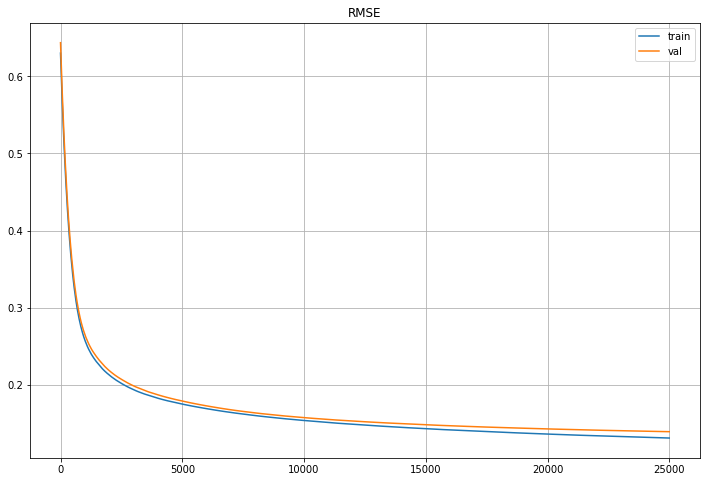

Score:
Validation mape: 0.59%
Test mape: 0.59%


,target,predict
22067,11000000.0,1.036966e+07
16510,11300000.0,1.090496e+07
12423,7030560.0,7.422473e+06
39858,5320000.0,5.342961e+06
26087,3070000.0,2.847918e+06
...,...,...
29020,6960600.0,6.644370e+06
17844,6710000.0,7.265356e+06
25697,3800000.0,4.094375e+06
4212,8960319.0,8.226243e+06


In [33]:
ctr = CatBoostRegressor( loss_function = 'RMSE',
                         eval_metric = 'MAPE',
                         learning_rate=0.002,
                         iterations=25000, # обучаем до overfitting'a
                         l2_leaf_reg=2,
                         depth=5,
                         bootstrap_type = 'Bernoulli', # Bayesian Bernoulli
                         one_hot_max_size = 77,
                         random_seed=RANDOM_SEED,
                         od_type='Iter',
                         od_wait=1000,
                         task_type='CPU')

m.fit_model(df, ctr)

# GRID SEARCH

In [ ]:
def search_best_params(data, grid, TRAIN_RATIO=0.75, VALIDATION_RATIO=0.15, 
                       TEST_RATIO=0.10, RANDOM_SEED=42, VERBOSE=500):
    
    """
    Description:
    
        Функция перебора параметров модели, для поиска лучших значений.
    
    Parametrs:
   
        data                  - таблица с данными                                   | DataFrame
        grid                  - словарь с параметрами, среди которых ищем лучшие    | {dict}
        TRAIN_RATIO           - объем тренировочных данных                          | float       | default - 0.75
        VALIDATION_RATIO      - объем валидационных данных                          | float       | default - 0.15
        TEST_RATIO            - объем тестовых данных                               | float       | default - 0.10
        RANDOM_SEED           - константа для воспроизводимости эксперементов       | int         | default - 42
        VERBOSE               - Как часто выводить информацию об обучении,          | int, bool   | default - 500
                                если передаем int. Выводить всю информацию или
                                не выводить, если передем bool 
                                
            
    """
    
    """ Train, validation, test split """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - TRAIN_RATIO, 
                                                        shuffle = True, random_state = RANDOM_SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO), 
                                                    shuffle = True, random_state = RANDOM_SEED)
    
    """ Data preparetion for CatBoost """
    train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)   # Тренировочные данные
    val_data  = Pool(data=X_val, label=y_val, cat_features=categorical_features)        # Валидационные данные
    test_data = Pool(data=X_test, cat_features=categorical_features)                    # Тестовые данные
    
    """ Grid search """
    model = CatBoostRegressor()
    grid_search_result = model.grid_search(param_grid=grid, 
                                           X=train_data, 
                                           y=val_data, 
                                           partition_random_seed=RANDOM_SEED,
                                           verbose=VERBOSE)
    
    return grid_search_result

# MODEL

In [ ]:
def fit_model(data, categorical_features, numerical_features, ctr, TRAIN_RATIO=0.75, 
              VALIDATION_RATIO=0.15, TEST_RATIO=0.10, RANDOM_SEED=42, metric='RMSE', VERBOSE=1000):
    

    """ 
    Description:

        Функция нормализует данные, обучает модель, рисует график обучения, возвращает датафрейм с результатом.

    Parametrs:

        data                  - таблица с данными                                   | DataFrame
        categorical_features  - категориальные признаки                             | [list]
        numerical_features    - числовые признаки                                   | [list]
        ctr                   - CatBoostRegressor()                                 | object
        TRAIN_RATIO           - объем тренировочных данных                          | float       | default - 0.75
        VALIDATION_RATIO      - объем валидационных данных                          | float       | default - 0.15
        TEST_RATIO            - объем тестовых данных                               | float       | default - 0.10
        RANDOM_SEED           - константа для воспроизводимости эксперементов       | int         | default - 42
        metric                - метрика для графика                                 | str         | default - RMSE
                              (должна совпадать с метрикой модели)
        VERBOSE               - Как часто выводить информацию об обучении,          | int, bool   | default - 1000
                                если передаем int. Выводить всю информацию или
                                не выводить, если передем bool 

    Return:

        result                - датафрейм с истинными и предсказанными значениям    | DataFrame
    
    """

    """ Normalization """
    MMS = MinMaxScaler()
    MMS.fit(df[numerical_features])
    data[numerical_features] = MMS.transform(data[numerical_features])
    print('Data: \n')
    display(data.head(5))

    """ Train, validation, test split """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - TRAIN_RATIO, 
                                                        shuffle = True, random_state = RANDOM_SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO), 
                                                    shuffle = True, random_state = RANDOM_SEED)

    """ Data preparetion for CatBoost """
    train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)   # Тренировочные данные
    val_data  = Pool(data=X_val, label=y_val, cat_features=categorical_features)        # Валидационные данные
    test_data = Pool(data=X_test, cat_features=categorical_features)                    # Тестовые данные

    """ Fit model """
    print('\n')
    print('Learning...')
    model = ctr.fit(train_data,
                    eval_set=val_data,
                    verbose_eval=VERBOSE,
                    use_best_model=True)

    """ Learning curve """
    plt.figure(figsize=(12,8))
    plt.title(metric)
    plt.plot(model.evals_result_['learn'][metric], label='train')
    plt.plot(model.evals_result_['validation'][metric], label='val')
    plt.legend()
    plt.grid()
    plt.show()

    """ Val predict """
    print('Score:')
    val_predict = model.predict(X_val)
    print(f"Validation mape: {(mape(y_val, val_predict))*100:0.2f}%")

    """ Test Predict """
    predict = model.predict(test_data)
    result_dict = {'target': np.expm1(y_test), 'predict': np.expm1(predict)}
    result = pd.DataFrame(data = result_dict)
    print(f"Test mape: {(mape(y_test, predict))*100:0.2f}%")

    return result

Data: 



,flat_type,object_type,rooms,floors,square,price,build_matireal,district_rating,underground,total_floors,metro_station,district
0,Квартира,Новостройка,2,11,0.496283,16.359441,Монолит,"4,0",0.2000,12,Звездная,Московский
1,Квартира,Новостройка,1,18,0.448009,15.967274,Монолит,"3,9",0.7200,20,Комендантский проспект,Приморский
2,Квартира,Вторичная,3,1,0.518702,15.363073,Панель,"3,6",0.2000,5,Обухово,Невский
3,Квартира,Вторичная,1,10,0.457967,16.341239,Монолит,"3,8",0.5600,14,Площадь Ленина,Калининский
4,Квартира,Вторичная,1,6,0.455073,16.461685,Монолит,"3,7",0.1594,10,Площадь А. Невского,Центральный




Learning...
0:	learn: 0.0310924	test: 0.0316951	best: 0.0316951 (0)	total: 5.32ms	remaining: 2m 12s
1000:	learn: 0.0123927	test: 0.0127318	best: 0.0127318 (1000)	total: 4.29s	remaining: 1m 42s
2000:	learn: 0.0100117	test: 0.0102717	best: 0.0102717 (2000)	total: 8.36s	remaining: 1m 36s
3000:	learn: 0.0089980	test: 0.0092003	best: 0.0092003 (3000)	total: 12.4s	remaining: 1m 30s
4000:	learn: 0.0084001	test: 0.0085720	best: 0.0085720 (4000)	total: 16.3s	remaining: 1m 25s
5000:	learn: 0.0079916	test: 0.0081419	best: 0.0081419 (5000)	total: 20.3s	remaining: 1m 20s
6000:	learn: 0.0076792	test: 0.0078073	best: 0.0078073 (6000)	total: 24.3s	remaining: 1m 16s
7000:	learn: 0.0074162	test: 0.0075294	best: 0.0075294 (7000)	total: 28.2s	remaining: 1m 12s
8000:	learn: 0.0072005	test: 0.0073054	best: 0.0073054 (8000)	total: 32.2s	remaining: 1m 8s
9000:	learn: 0.0070147	test: 0.0071196	best: 0.0071196 (9000)	total: 36.1s	remaining: 1m 4s
10000:	learn: 0.0068607	test: 0.0069672	best: 0.0069672 (10000)

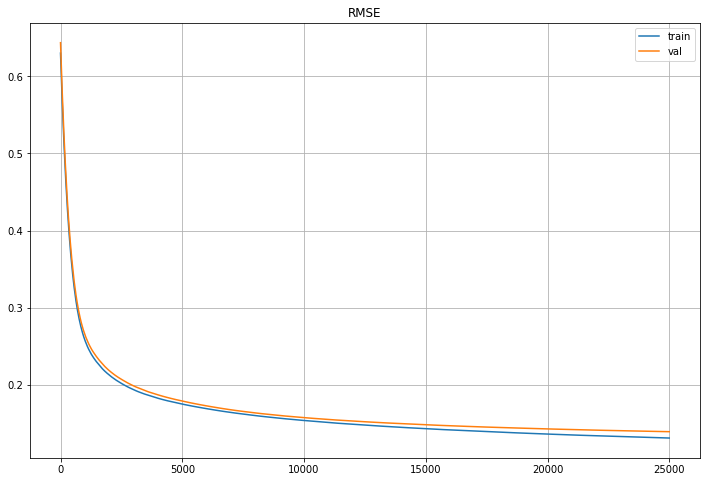

Score:
Validation mape: 0.59%
Test mape: 0.59%


,target,predict
22067,11000000.0,1.036966e+07
16510,11300000.0,1.090496e+07
12423,7030560.0,7.422473e+06
39858,5320000.0,5.342961e+06
26087,3070000.0,2.847918e+06
...,...,...
29020,6960600.0,6.644370e+06
17844,6710000.0,7.265356e+06
25697,3800000.0,4.094375e+06
4212,8960319.0,8.226243e+06


In [ ]:
cat = ['flat_type', 'rooms', 'object_type', 'floors', 'build_matireal', 
       'district_rating', 'total_floors',  'metro_station',  'district']
num = ['square', 'underground']

ctr = CatBoostRegressor( loss_function = 'RMSE',
                         eval_metric = 'MAPE',
                         learning_rate=0.002,
                         iterations=25000, # обучаем до overfitting'a
                         l2_leaf_reg=2,
                         depth=5,
                         bootstrap_type = 'Bernoulli', # Bayesian Bernoulli
                         one_hot_max_size = 77,
                         random_seed=RANDOM_SEED,
                         od_type='Iter',
                         od_wait=1000,
                         task_type='CPU')

results = fit_model(df, cat, num, ctr)

results